In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score

import tensorflow as tf
plt.style.use('classic')

from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.utils import normalize, to_categorical
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adam

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

In [2]:
# Function to extract audio features from audio files in the input directory and save to a CSV file.

def extract_audio_features(input_path, output_csv):

    frame_size = 2048
    hop_length = 126
    num_frames = 10

    # Create a list to store the extracted features
    extracted_features = []

    # Iterate through the genre folders
    for genre in os.listdir(input_path):
        genre_path = os.path.join(input_path, genre)

        # Check if the item in the directory is a directory itself
        if not os.path.isdir(genre_path):
            continue

        # Iterate through audio files in the genre folder
        for audio_file in os.listdir(genre_path):
            audio_path = os.path.join(genre_path, audio_file)
            signal, sr = librosa.load(audio_path)

            # Iterate through frames within the audio
            frames = [signal[i:i + frame_size] for i in range(0, min(len(signal) - frame_size + 1, num_frames * hop_length), hop_length)]

            # Extract audio features for each frame
            for frame in frames:
                mfcc_features = librosa.feature.mfcc(y=frame, sr=sr)
                chroma_features = librosa.feature.chroma_stft(y=frame, sr=sr)
                zero_crossing_rate = librosa.feature.zero_crossing_rate(y=frame)
                spectral_centroid = librosa.feature.spectral_centroid(y=frame, sr=sr)
                spectral_rolloff = librosa.feature.spectral_rolloff(y=frame, sr=sr)
                chroma_energy = librosa.feature.chroma_cens(y=frame, sr=sr)

                # Create a dictionary to store the feature values
                feature_dict = {
                    "chroma_energy": round(chroma_energy.mean(), 3),
                    "mfcc": round(mfcc_features.mean(), 3),
                    "chroma_stft": round(chroma_features.mean(), 3),
                    "zero_crossing_rate": round(zero_crossing_rate.mean(), 3),
                    "spectral_centroid": round(spectral_centroid.mean(), 3),
                    "spectral_rolloff": round(spectral_rolloff.mean(), 3),
                    "genre": genre,
                }

                # Append the feature dictionary to the list
                extracted_features.append(feature_dict)

    # Create a DataFrame from the list of feature dictionaries
    extracted_data = pd.DataFrame(extracted_features)

    # Save the extracted features to a CSV file
    extracted_data.to_csv(output_csv, index=False)

    return extracted_data


In [3]:
# Extract audio features and save to a CSV file
extracted_data = extract_audio_features("/content/drive/MyDrive/Colab Notebooks/Data/genres", "AudioExtractedData.csv")

In [4]:
extracted_data.head()

,chroma_energy,mfcc,chroma_stft,zero_crossing_rate,spectral_centroid,spectral_rolloff,genre
0,0.237,-4.864,0.395,0.054,1570.085,3260.127,classical
1,0.228,-5.434,0.398,0.053,1562.085,3257.974,classical
2,0.212,-5.420,0.367,0.053,1504.138,3133.081,classical
3,0.229,-5.270,0.388,0.052,1568.912,3264.434,classical
4,0.227,-5.356,0.388,0.052,1533.495,3227.827,classical


In [5]:
# import dataset stored as "AudioExtractedFeature.csv"

df = pd.read_csv("/content/AudioExtractedData.csv")


In [6]:
df

,chroma_energy,mfcc,chroma_stft,zero_crossing_rate,spectral_centroid,spectral_rolloff,genre
0,0.237,-4.864,0.395,0.054,1570.085,3260.127,classical
1,0.228,-5.434,0.398,0.053,1562.085,3257.974,classical
2,0.212,-5.420,0.367,0.053,1504.138,3133.081,classical
3,0.229,-5.270,0.388,0.052,1568.912,3264.434,classical
4,0.227,-5.356,0.388,0.052,1533.495,3227.827,classical
...,...,...,...,...,...,...,...
9995,0.213,-5.277,0.382,0.037,1544.492,2986.655,rock
9996,0.223,-5.458,0.389,0.038,1476.564,2878.989,rock
9997,0.237,-5.217,0.383,0.040,1634.884,3197.681,rock
9998,0.250,-5.109,0.388,0.042,1401.009,2691.650,rock


## **Exploratory Data Analysis (EDA)**

In [7]:
# Function to plot audio waveforms from audio files in subfolders of the input directory.

from itertools import islice

def plot_waveforms(input_path, num_rows=2, num_cols=5, output_filename='waveforms_for_audio_files.png'):

    subfolders = next(os.walk(input_path))[1]
    num_rows = min(len(subfolders), num_rows)
    num_cols = min(num_cols, len(subfolders) // num_rows)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6), squeeze=False)

    for i, folder in enumerate(subfolders):
        if i >= num_rows * num_cols:
            break
        folder_path = os.path.join(input_path, folder)

        # Use itertools.islice to limit the number of files processed
        for file in islice(os.listdir(folder_path), num_cols):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path)
                row = i // num_cols
                col = i % num_cols
                axs[row, col].plot(audio, linewidth=1)
                axs[row, col].set_title(folder)
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])

    plt.tight_layout()
    fig.suptitle("Waveforms")
    fig.subplots_adjust(top=0.90)
    plt.savefig(output_filename, dpi=300)
    plt.show()



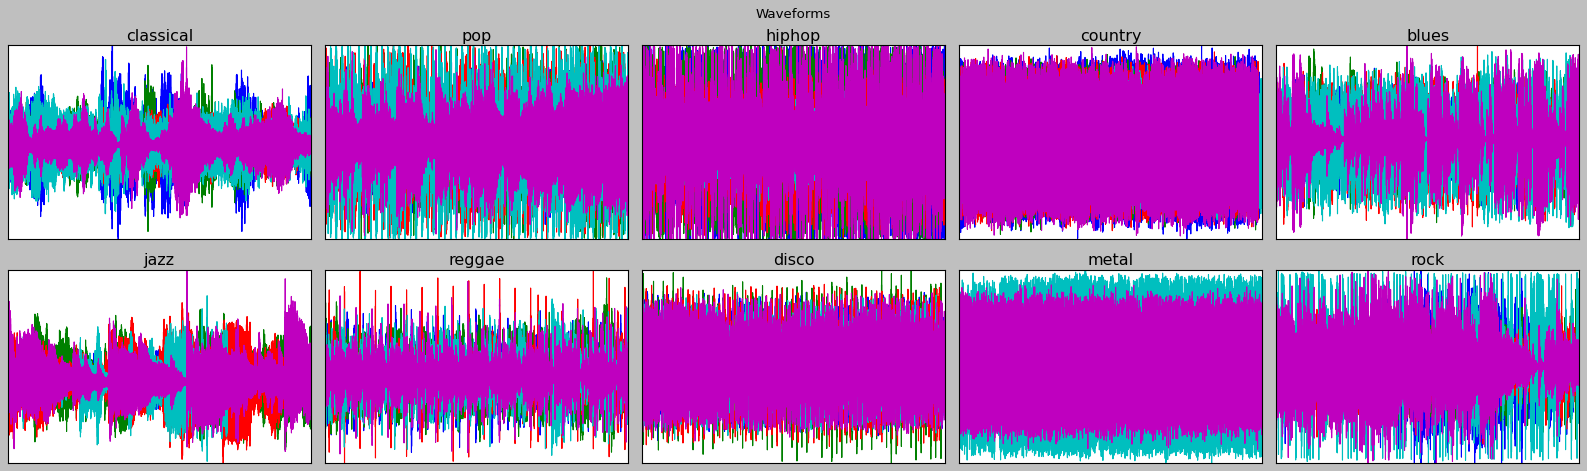

In [8]:
# Function to plot the music waveform   df

def plot_waveform_music():
    input_path = '/content/drive/MyDrive/Colab Notebooks/Data/genres'
    num_rows = 2
    num_cols = 5
    output_filename = 'waveforms_for_audio_files.png'

    plot_waveforms(input_path, num_rows, num_cols, output_filename)

# Function call
plot_waveform_music()


**MFCC Spectrograms Plot**

In [9]:
# Function to plot MFCC spectrograms from audio files in subfolders of the input directory.

def plot_mfcc_spectrograms(input_path, num_rows=2, num_cols=5, output_filename='mfcc_spectrograms.png'):

    # Get subfolders in the input directory
    subfolders = next(os.walk(input_path))[1]
    num_rows = min(len(subfolders), num_rows)
    num_cols = min(num_cols, len(subfolders) // num_rows)

    # Creating a subplot grid
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6), squeeze=False)

    for i, folder in enumerate(subfolders):
        if i >= num_rows * num_cols:
            break
        folder_path = os.path.join(input_path, folder)

        for col, file in enumerate(os.listdir(folder_path)[:num_cols]):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path)
                mfcc_features = librosa.feature.mfcc(y=audio, sr=sr)
                row = i // num_cols
                col = i % num_cols
                librosa.display.specshow(mfcc_features, sr=sr, x_axis='time', ax=axs[row, col])
                axs[row, col].set_title(folder)
                axs[row, col].set_xlabel('Time (s)')
                axs[row, col].set_ylabel('MFCC')

    # Save and show the plot
    save_and_show_plot(fig, output_filename)


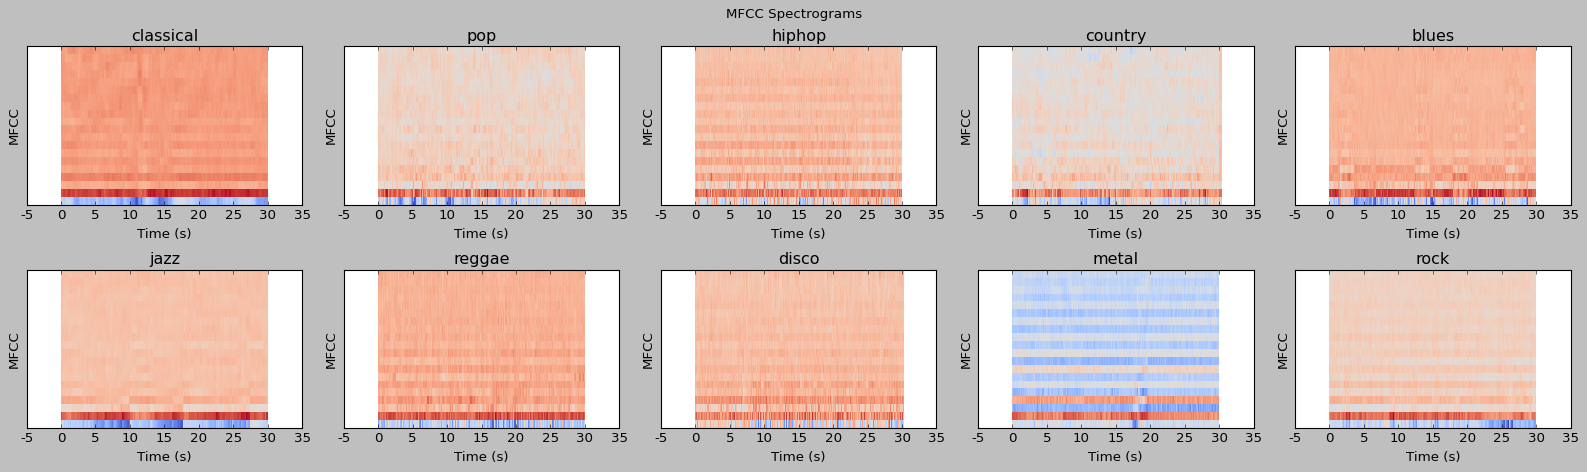

In [10]:
# Function to save and display the plot.

def save_and_show_plot(fig, output_filename):

    plt.tight_layout()
    fig.suptitle("MFCC Spectrograms")
    fig.subplots_adjust(top=0.90)
    plt.savefig(output_filename, dpi=300)
    plt.show()

# function call
plot_mfcc_spectrograms("/content/drive/MyDrive/Colab Notebooks/Data/genres")

**Chroma Energy Spectrograms Plot**

In [11]:
# Function to plot Chroma Energy spectrograms from audio files in subfolders of the input directory.

def plot_chroma_energy_spectrograms(input_path, num_rows=2, num_cols=5, output_filename='chroma_energy_spectrograms.png'):

    # Get subfolders in the input directory
    subfolders = next(os.walk(input_path))[1]
    num_rows = min(len(subfolders), num_rows)
    num_cols = min(num_cols, len(subfolders) // num_rows)

    # Creating a subplot grid
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6), squeeze=False)

    for i, folder in enumerate(subfolders):
        if i >= num_rows * num_cols:
            break
        folder_path = os.path.join(input_path, folder)

        for col, file in enumerate(os.listdir(folder_path)[:num_cols]):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path)
                chroma_energy = librosa.feature.chroma_cens(y=audio, sr=sr)
                row = i // num_cols
                col = i % num_cols
                librosa.display.specshow(chroma_energy, sr=sr, x_axis='time', ax=axs[row, col])
                axs[row, col].set_title(folder)
                axs[row, col].set_xlabel('Time (s)')
                axs[row, col].set_ylabel('Chroma Energy')

    # Save and show the plot
    save_and_show_plot(fig, output_filename)


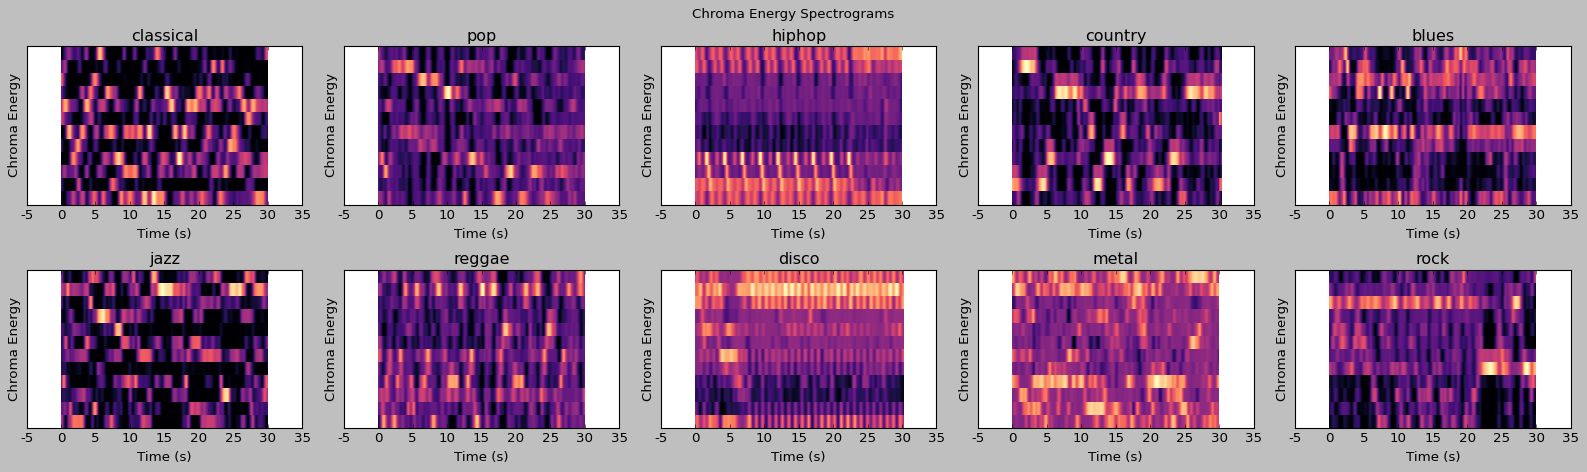

In [12]:
# Function to save and display the plot.

def save_and_show_plot(fig, output_filename):

    plt.tight_layout()
    fig.suptitle("Chroma Energy Spectrograms")
    fig.subplots_adjust(top=0.90)
    plt.savefig(output_filename, dpi=300)
    plt.show()

# function call
plot_chroma_energy_spectrograms("/content/drive/MyDrive/Colab Notebooks/Data/genres")

**Chroma STFT Spectrograms Plot**

In [13]:
# Function to plot Chroma STFT spectrograms from audio files in subfolders of the input directory.

def plot_chroma_stft_spectrograms(input_path, num_rows=2, num_cols=5, output_filename='chroma_stft_spectrograms.png'):

    # Get subfolders in the input directory
    subfolders = next(os.walk(input_path))[1]
    num_rows = min(len(subfolders), num_rows)
    num_cols = min(num_cols, len(subfolders) // num_rows)

    # Creating a subplot grid
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6), squeeze=False)

    for i, folder in enumerate(subfolders):
        if i >= num_rows * num_cols:
            break
        folder_path = os.path.join(input_path, folder)

        for col, file in enumerate(os.listdir(folder_path)[:num_cols]):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path)
                chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
                row = i // num_cols
                col = i % num_cols
                librosa.display.specshow(chroma_stft, sr=sr, x_axis='time', ax=axs[row, col])
                axs[row, col].set_title(folder)
                axs[row, col].set_xlabel('Time (s)')
                axs[row, col].set_ylabel('Chroma STFT')

    # Save and show the plot
    save_and_show_plot(fig, output_filename)


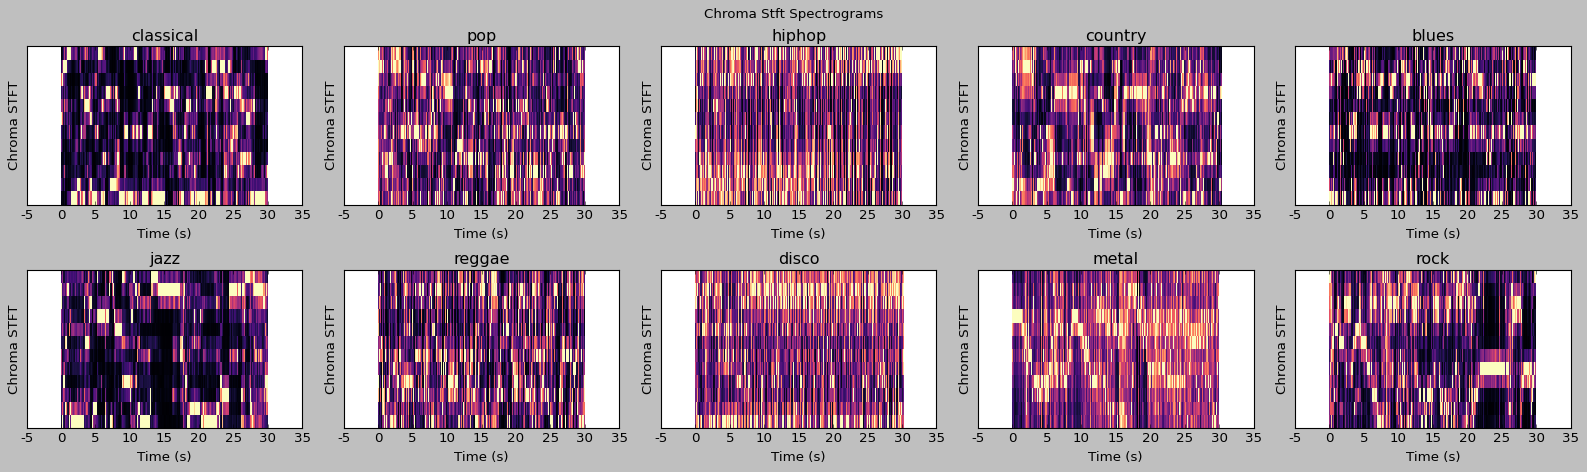

In [14]:
# Function to save and display the plot.

def save_and_show_plot(fig, output_filename):

    plt.tight_layout()
    fig.suptitle("Chroma Stft Spectrograms")
    fig.subplots_adjust(top=0.90)
    plt.savefig(output_filename, dpi=300)
    plt.show()

# function call
plot_chroma_stft_spectrograms("/content/drive/MyDrive/Colab Notebooks/Data/genres")

**Zero Crossing Plot**

In [15]:
# Function to plot Zero Crossing Rate from audio files in subfolders of the input directory.

def plot_zero_crossing_rate_in_audio_files(input_path, num_rows=2, num_cols=5, output_filename='zero_crossing_rate_plot.png'):

    # Get subfolders in the input directory
    subfolders = next(os.walk(input_path))[1]
    num_rows = min(len(subfolders), num_rows)
    num_cols = min(num_cols, len(subfolders) // num_rows)

    # Creating a subplot grid
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6), squeeze=False)

    for i, folder in enumerate(subfolders):
        if i >= num_rows * num_cols:
            break
        folder_path = os.path.join(input_path, folder)

        for col, file in enumerate(os.listdir(folder_path)[:num_cols]):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path)
                zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
                row = i // num_cols
                col = i % num_cols
                time = librosa.times_like(zero_crossing_rate, sr=sr)
                axs[row, col].plot(time, zero_crossing_rate[0])
                axs[row, col].set_title(folder)
                axs[row, col].set_xlabel('Time (s)')
                axs[row, col].set_ylabel('Zero Crossing Rate')

    # Save and show the plot
    save_and_show_plot(fig, output_filename)


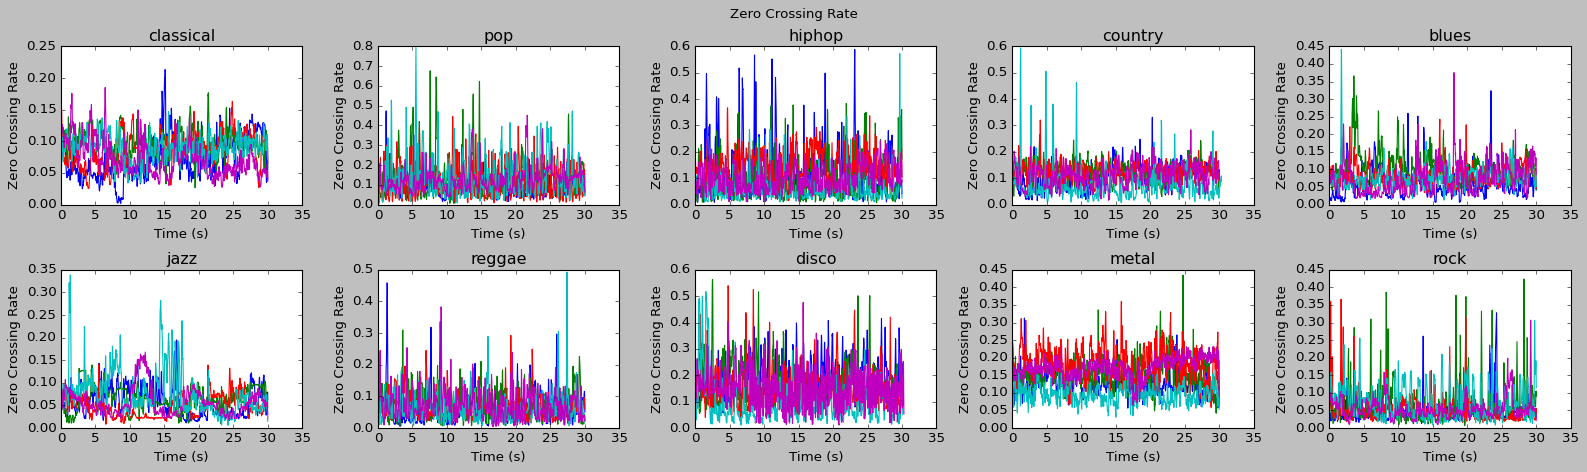

In [16]:
# Function to save and display the plot.

def save_and_show_plot(fig, output_filename):

    plt.tight_layout()
    fig.suptitle("Zero Crossing Rate")
    fig.subplots_adjust(top=0.90)
    plt.savefig(output_filename, dpi=300)
    plt.show()

# function call
plot_zero_crossing_rate_in_audio_files("/content/drive/MyDrive/Colab Notebooks/Data/genres")

**Zero Crossing Count**

In [17]:
# Function to count zero crossings in audio files within subfolders of the input directory.

def count_zero_crossings_in_audio_files(input_path):

    subfolders = next(os.walk(input_path))[1]

    for folder in subfolders:
        folder_path = os.path.join(input_path, folder)
        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                audio, sr = librosa.load(file_path)

                # Count zero crossings in the audio
                zero_crossings_count = sum(librosa.zero_crossings(audio))

                print(f"File: {file}, Genre: {folder}, Zero Crossings Count: {zero_crossings_count}")

# function call
count_zero_crossings_in_audio_files("/content/drive/MyDrive/Colab Notebooks/Data/genres")


File: classical.00007.wav, Genre: classical, Zero Crossings Count: 48462
File: classical.00000.wav, Genre: classical, Zero Crossings Count: 65096
File: classical.00001.wav, Genre: classical, Zero Crossings Count: 58181
File: classical.00002.wav, Genre: classical, Zero Crossings Count: 59685
File: classical.00006.wav, Genre: classical, Zero Crossings Count: 48313
File: classical.00008.wav, Genre: classical, Zero Crossings Count: 52213
File: classical.00003.wav, Genre: classical, Zero Crossings Count: 72207
File: classical.00005.wav, Genre: classical, Zero Crossings Count: 49845
File: classical.00004.wav, Genre: classical, Zero Crossings Count: 74801
File: classical.00023.wav, Genre: classical, Zero Crossings Count: 29308
File: classical.00017.wav, Genre: classical, Zero Crossings Count: 53725
File: classical.00020.wav, Genre: classical, Zero Crossings Count: 46256
File: classical.00018.wav, Genre: classical, Zero Crossings Count: 46839
File: classical.00019.wav, Genre: classical, Zero C

**Spectral Centroid Plot**

In [18]:
# Function to plot spectral centroid in audio files within subfolders of the input directory.

def plot_spectral_centroid_in_audio_files(input_path, num_rows=2, num_cols=5, output_filename='spectral_centroid.png'):

    subfolders = next(os.walk(input_path))[1]

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6), squeeze=False)

    for folder, i in zip(subfolders, range(num_rows * num_cols)):
        folder_path = os.path.join(input_path, folder)

        # Use a list comprehension to filter audio files and process them
        audio_files = [file for file in os.listdir(folder_path) if file.endswith('.wav')]
        for col, file in enumerate(audio_files[:num_cols]):
            file_path = os.path.join(folder_path, file)
            audio, sr = librosa.load(file_path)

            # Compute spectral centroid and plot it
            plot_spectral_centroid(audio, sr, i, num_cols, axs, folder)

    # Save and show the plot
    save_and_show_plot(fig, output_filename)




In [19]:
# Function to compute spectral centroid and plot it for a given audio file.

def plot_spectral_centroid(audio, sr, i, num_cols, axs, folder):

    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)
    time = librosa.times_like(spectral_centroids, sr=sr)
    row = i // num_cols
    col = i % num_cols
    axs[row, col].plot(time, spectral_centroids[0])
    axs[row, col].set_title(folder)
    axs[row, col].set_xlabel('Time (s)')
    axs[row, col].set_ylabel('Spectral Centroid')


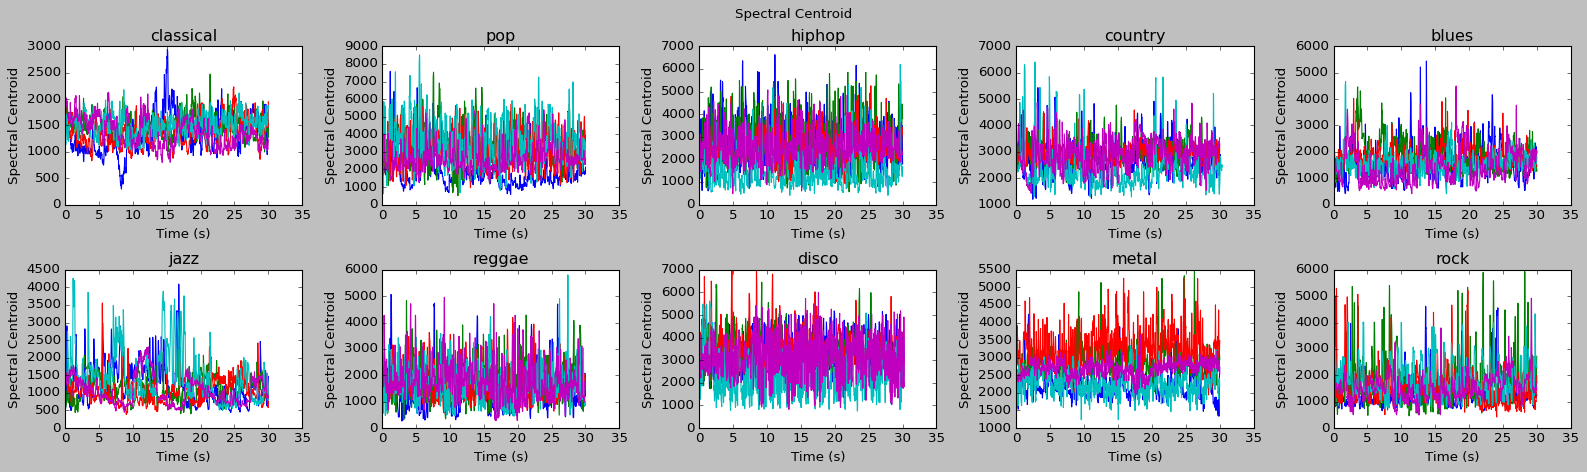

In [20]:
# Function to save and display the plot.

def save_and_show_plot(fig, output_filename):

    plt.tight_layout()
    fig.suptitle("Spectral Centroid")
    fig.subplots_adjust(top=0.90)
    plt.savefig(output_filename, dpi=300)
    plt.show()

# function call
plot_spectral_centroid_in_audio_files("/content/drive/MyDrive/Colab Notebooks/Data/genres")

**Spectral Rolloff Plot**

In [21]:
# Function to plot spectral rolloff in audio files within subfolders of the input directory.

def plot_spectral_rolloff_in_audio_files(input_path, num_rows=2, num_cols=5, output_filename='spectral_rolloff.png'):

    subfolders = next(os.walk(input_path))[1]

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6), squeeze=False)

    for folder, i in zip(subfolders, range(num_rows * num_cols)):
        folder_path = os.path.join(input_path, folder)

        # Use a list comprehension to filter audio files and process them
        audio_files = [file for file in os.listdir(folder_path) if file.endswith('.wav')]
        for col, file in enumerate(audio_files[:num_cols]):
            file_path = os.path.join(folder_path, file)
            audio, sr = librosa.load(file_path)

            # Compute spectral centroid and plot it
            plot_spectral_centroid(audio, sr, i, num_cols, axs, folder)

    # Save and show the plot
    save_and_show_plot(fig, output_filename)


In [22]:
# Function to compute spectral rolloff and plot it for a given audio file.

def plot_spectral_rolloff(audio, sr, i, num_cols, axs, folder):

    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    time = librosa.times_like(spectral_rolloff, sr=sr)

    # Determine the subplot index dynamically

    row = i // num_cols
    col = i % num_cols
    axs[row, col].plot(time, spectral_rolloff[0])
    axs[row, col].set_title(folder)
    axs[row, col].set_xlabel('Time (s)')
    axs[row, col].set_ylabel('Spectral Rolloff')



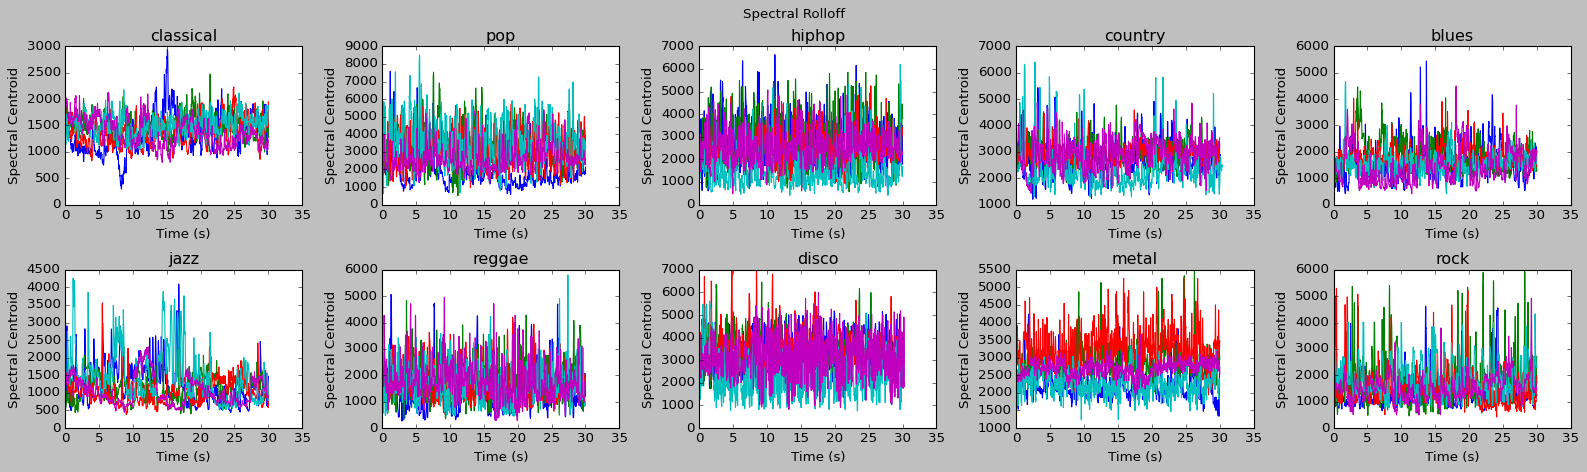

In [23]:
# Function to save and display the plot.

def save_and_show_plot(fig, output_filename):

    plt.tight_layout()
    fig.suptitle("Spectral Rolloff")
    fig.subplots_adjust(top=0.90)
    plt.savefig(output_filename, dpi=300)
    plt.show()

# function call
plot_spectral_rolloff_in_audio_files("/content/drive/MyDrive/Colab Notebooks/Data/genres")

## **Building Model Pipeline**

In [24]:
# Extracting features from a DataFrame and return the shape of the resulting array.

def extract_features_and_shape(data):

    X = np.array(extracted_data.iloc[:, :-1], dtype='float32')
    return X, X.shape

X, shape = extract_features_and_shape(extracted_data)
print("Features Array Shape:", shape)


Features Array Shape: (10000, 6)


In [25]:
# Encode and convert class labels to categorical format.

def encode_and_categorical_labels(data, num_classes=10):

    class_list = df['genre']
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(class_list)
    # categorical_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=num_classes)
    categorical_labels = to_categorical(encoded_labels, num_classes=num_classes)
    return categorical_labels, categorical_labels.shape

y, y_shape = encode_and_categorical_labels(extracted_data)
print("Categorical Labels Shape:", y_shape)


Categorical Labels Shape: (10000, 10)


In [26]:
# Split and prepare the data into training, validation, and test sets.

def split_and_prepare_data(X, y, test_size=0.1, validation_size=0.1):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # Add a channel dimension for convolutional networks
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

X_train, X_validation, X_test, y_train, y_validation, y_test = split_and_prepare_data(X, y)


In [27]:
# Scale input features using StandardScaler.

def scale_features(X):

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(X)
    return scaled_features

scaled_X = scale_features(X)


In [28]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

In [29]:
kernel_initializer =  'random_uniform'  #Also try 'zeros', 'random_uniform', 'he_uniform', 'glorot_uniform'


# Define the metrics
precision = Precision()
recall = Recall()


num_classes = 10

model2 = Sequential()

model2.add(Dense(128, activation='relu', kernel_initializer=kernel_initializer, input_shape=(X_train.shape[1],)))
model2.add(Dropout(0.1))
model2.add(Dense(256, activation='relu', kernel_initializer=kernel_initializer))
model2.add(Dropout(0.1))
model2.add(BatchNormalization())
model2.add(Dense(num_classes, activation='softmax'))


# optimizer = adam, opt1, opt2
opt1 = SGD(lr=0.001, momentum=0.9)
opt2 = RMSprop(lr=0.001, decay=1e-6)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                        

In [30]:
# Train the model
history = model2.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/100
500/500 [==============================] - 5s 5ms/step - loss: 1.8850 - accuracy: 0.3325 - precision: 0.6768 - recall: 0.1084 - val_loss: 1.9347 - val_accuracy: 0.3575 - val_precision: 1.0000 - val_recall: 0.0125
Epoch 2/100
500/500 [==============================] - 3s 6ms/step - loss: 1.7669 - accuracy: 0.3629 - precision: 0.6877 - recall: 0.1351 - val_loss: 1.7679 - val_accuracy: 0.3645 - val_precision: 0.5731 - val_recall: 0.1765
Epoch 3/100
500/500 [==============================] - 3s 7ms/step - loss: 1.7065 - accuracy: 0.3865 - precision: 0.6775 - recall: 0.1517 - val_loss: 1.6396 - val_accuracy: 0.4055 - val_precision: 0.6447 - val_recall: 0.2105
Epoch 4/100
500/500 [==============================] - 3s 5ms/step - loss: 1.6443 - accuracy: 0.4123 - precision: 0.6912 - recall: 0.1729 - val_loss: 1.6274 - val_accuracy: 0.4250 - val_precision: 0.6501 - val_recall: 0.2090
Epoch 5/100
500/500 [==============================] - 2s 4ms/step - loss: 1.6008 - accuracy: 0.4244

In [31]:
# Evaluate the model
results = model2.evaluate(X_test, y_test)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])


63/63 [==============================] - 0s 2ms/step - loss: 0.7967 - accuracy: 0.7355 - precision: 0.7931 - recall: 0.6595
Test Loss: 0.7966752648353577
Test Accuracy: 0.7354999780654907


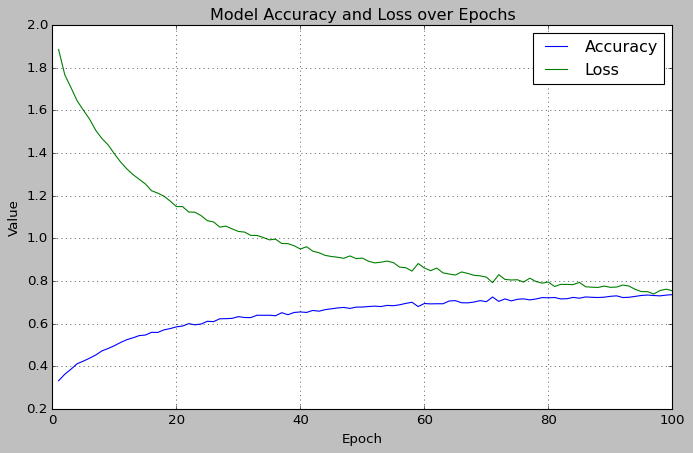

In [32]:
# Plot the training accuracy and loss over epochs.

def plot_training_history(history):

    epochs = range(1, len(history.history['accuracy']) + 1)
    accuracy = history.history['accuracy']
    loss = history.history['loss']

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, accuracy, label='Accuracy')
    plt.plot(epochs, loss, label='Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Model Accuracy and Loss over Epochs')
    plt.grid()
    plt.legend()
    plt.show()


hist = history
plot_training_history(hist)


In [33]:
# Calculate and print the test precision and recall.

def calculate_precision_recall(y_true, y_pred_prob):


    y_pred = np.argmax(y_pred_prob, axis=1)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    print("Test Precision:", precision)
    print("Test Recall:", recall)


y_true = np.argmax(y_test, axis=1)
y_pred_prob = model2.predict(X_test)
calculate_precision_recall(y_true, y_pred_prob)


63/63 [==============================] - 0s 2ms/step
Test Precision: 0.73654615659891
Test Recall: 0.7355
